In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import numexpr as ne
import time
import copy
import sys

from tqdm import tqdm
from sklearn.metrics import accuracy_score, log_loss

import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../pytorch_utils/')
from utils import train, evaluate, get_data, top5_accuracy, per_class_accuracy, count_params

In [3]:
import torch.cuda
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.benchmark = True

# Load data

In [5]:
%%time
X_train, X_val, Y_train, Y_val = get_data()
train_size = len(X_train)
val_size = len(X_val)
print(train_size, val_size)

51200 5120
CPU times: user 1min 31s, sys: 10.5 s, total: 1min 42s
Wall time: 40.8 s


# Create iterators

In [6]:
val_data = TensorDataset(
    torch.FloatTensor(X_val), 
    torch.LongTensor(Y_val)
)

val_iterator = DataLoader(
    val_data, batch_size=64, shuffle=True, pin_memory=True
)

In [7]:
batch_size = 64

In [8]:
train_data = TensorDataset(
    torch.FloatTensor(X_train), 
    torch.LongTensor(Y_train)
)

train_iterator = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Model

In [9]:
from model_squeezenet import make_model

In [10]:
model, criterion, optimizer = make_model()

In [11]:
count_params(model)

853824

# Train

In [12]:
n_epochs = 12
validation_step = 100
n_batches = int(np.ceil(train_size/batch_size))
M = 4
T = n_batches*n_epochs
initial = 0.01
n_batches

800

In [13]:
def lr_scheduler(optimizer, step):
    
    global initial
    decay = np.cos(np.pi*((step - 1) % (T // M))/(T // M)) + 1.0
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = initial*decay/2.0
    
    if (step - 1) % (T // M) == 0 and step != 1:
        # initial *= 0.5
        print('lr is reset:', initial)
        
    return optimizer

In [14]:
all_losses = []
all_models = []

In [15]:
%%time
running_loss = 0.0
running_accuracy = 0.0 
start = time.time()
model.train()

for epoch in range(0, n_epochs):
    for step, (x_batch, y_batch) in enumerate(train_iterator, 1 + epoch*n_batches):
        
        optimizer = lr_scheduler(optimizer, step)
        batch_loss, batch_accuracy = train(
            model, criterion, optimizer, 
            x_batch, y_batch
        )
        running_loss += batch_loss
        running_accuracy += batch_accuracy
        
        if step % validation_step == 0:
            model.eval()
            test_loss, test_accuracy = evaluate(
                model, criterion, val_iterator
            )
            end = time.time()
            
            print('{0:.2f}  {1:.3f} {2:.3f}  {3:.3f} {4:.3f}  {5:.3f}'.format(
                step/n_batches, running_loss/validation_step, test_loss, 
                running_accuracy/validation_step, test_accuracy, end - start
            ))
            all_losses += [(
                step/n_batches,
                running_loss/validation_step, test_loss, 
                running_accuracy/validation_step, test_accuracy
            )] 
            
            running_loss = 0.0
            running_accuracy = 0.0 
            start = time.time()
            model.train()
            
        if step % (T // M) == 0:
            
            print('saving')
            model.cpu()
            clone = copy.deepcopy(model)
            all_models += [clone.state_dict()]
            model.cuda()

0.12  3.608 2.599  0.293 0.416  13.492
0.25  2.324 2.388  0.466 0.463  12.565
0.38  2.131 2.171  0.503 0.510  12.530
0.50  1.994 2.188  0.529 0.489  12.568
0.62  1.926 2.230  0.539 0.479  12.576
0.75  1.904 1.988  0.542 0.522  12.544
0.88  1.846 1.977  0.551 0.522  12.524
1.00  1.812 1.962  0.565 0.531  12.536
1.12  1.557 1.997  0.622 0.534  12.533
1.25  1.590 1.954  0.608 0.522  12.572
1.38  1.505 1.870  0.627 0.559  12.541
1.50  1.487 1.883  0.633 0.541  12.512
1.62  1.405 1.786  0.652 0.591  12.500
1.75  1.321 1.622  0.673 0.611  12.501
1.88  1.248 1.824  0.680 0.574  12.533
2.00  1.217 1.619  0.695 0.612  12.566
2.12  0.977 1.631  0.750 0.609  12.477
2.25  0.914 1.673  0.766 0.614  12.471
2.38  0.887 1.521  0.777 0.629  12.489
2.50  0.858 1.498  0.782 0.648  12.488
2.62  0.795 1.405  0.798 0.674  12.524
2.75  0.763 1.427  0.814 0.665  12.561
2.88  0.738 1.468  0.822 0.656  12.550
3.00  0.731 1.516  0.821 0.646  12.587
saving
lr is reset: 0.01
3.12  1.735 2.324  0.575 0.476  12.570


# Loss/epoch

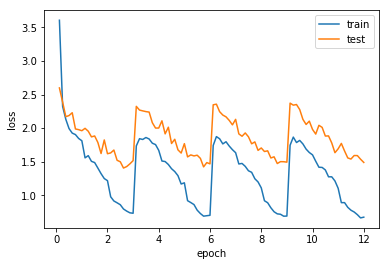

In [16]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

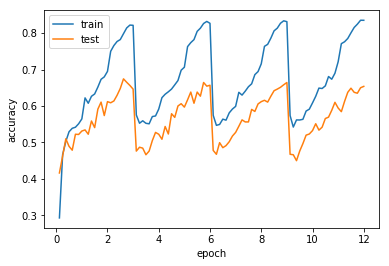

In [17]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='test');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

# Predict val. set

In [18]:
val_predictions = []

In [19]:
val_iterator_no_shuffle = DataLoader(
    val_data, batch_size=32, shuffle=False, pin_memory=True
)

In [20]:
%%time
# model.load_state_dict(all_models[-1])
model.eval()

for x_batch, _ in val_iterator_no_shuffle:

    x_batch = Variable(x_batch.cuda(), volatile=True)
    logits = model(x_batch)

    # compute probabilities
    probs = F.softmax(logits) 
    val_predictions += [probs.cpu().data.numpy()]

CPU times: user 6.25 s, sys: 1.18 s, total: 7.43 s
Wall time: 7.56 s


In [21]:
val_predictions = np.concatenate(val_predictions, axis=0)

In [22]:
accuracy_score(Y_val, val_predictions.argmax(1))

0.650390625

In [23]:
log_loss(Y_val, val_predictions)

1.4904862987702292

# Try ensemble

In [24]:
ensemble_predictions = {}

In [25]:
%%time
for i, state in enumerate(all_models):
    
    model.load_state_dict(state)
    ensemble_predictions[i] = []
    model.eval()
    
    for x_batch, _ in val_iterator_no_shuffle:

        x_batch = Variable(x_batch.cuda(), volatile=True)
        logits = model(x_batch)

        # compute probabilities
        probs = F.softmax(logits) 
        ensemble_predictions[i] += [probs.cpu().data.numpy()]

CPU times: user 24.8 s, sys: 4.6 s, total: 29.4 s
Wall time: 29.4 s


In [26]:
ensemble_predictions = {
    p: np.concatenate(ensemble_predictions[p], axis=0) 
    for p in ensemble_predictions
}

In [27]:
predictions = np.stack(ensemble_predictions.values()).mean(0)

In [28]:
accuracy_score(Y_val, predictions.argmax(1))

0.66425781250000004

In [29]:
log_loss(Y_val, predictions)

1.3973245316860676

In [30]:
top5_accuracy(Y_val, predictions)

0.86464843749999998

In [31]:
per_class_acc = per_class_accuracy(Y_val, predictions)
per_class_acc

array([ 0.8 ,  0.75,  0.7 ,  0.35,  0.85,  0.55,  0.4 ,  0.7 ,  0.75,
        0.6 ,  0.8 ,  0.85,  0.65,  0.55,  0.9 ,  0.55,  0.55,  0.55,
        0.65,  0.9 ,  0.9 ,  0.95,  0.7 ,  0.6 ,  0.65,  0.45,  0.75,
        0.55,  0.65,  0.3 ,  0.4 ,  0.7 ,  0.55,  0.7 ,  0.85,  0.8 ,
        0.75,  0.45,  0.45,  0.6 ,  0.75,  0.25,  0.75,  0.8 ,  0.55,
        0.85,  0.65,  0.45,  0.5 ,  0.8 ,  0.75,  0.5 ,  0.8 ,  0.75,
        0.45,  0.35,  0.65,  0.65,  0.2 ,  0.5 ,  0.5 ,  0.8 ,  0.7 ,
        0.75,  0.8 ,  0.8 ,  0.65,  0.75,  0.45,  0.6 ,  0.45,  0.95,
        0.9 ,  0.5 ,  0.4 ,  0.65,  0.95,  0.65,  0.55,  0.3 ,  0.75,
        0.8 ,  0.75,  0.8 ,  0.5 ,  0.75,  0.65,  0.55,  0.55,  0.85,
        0.8 ,  0.7 ,  0.7 ,  0.9 ,  0.85,  0.75,  0.5 ,  0.6 ,  0.75,
        0.8 ,  0.85,  0.7 ,  0.65,  0.8 ,  0.7 ,  0.6 ,  0.8 ,  0.25,
        0.85,  0.85,  0.75,  0.7 ,  0.8 ,  0.9 ,  0.6 ,  0.6 ,  0.75,
        0.55,  0.4 ,  0.75,  0.65,  0.25,  0.95,  0.5 ,  0.15,  0.35,
        0.85,  0.8 ,

# Error analysis

In [32]:
erroneous = Y_val != predictions.argmax(1)
n_errors = len(Y_val[erroneous])
n_errors

1719

In [33]:
to_show = np.random.choice(np.arange(0, n_errors), size=30, replace=False)

In [34]:
pictures = X_val[erroneous][to_show].copy()
pictures_predictions = predictions.argmax(1)[erroneous][to_show]
pictures_probs = predictions.max(1)[erroneous][to_show]
pictures_true = Y_val[erroneous][to_show]

In [35]:
mean = np.array([0.485, 0.456, 0.406], dtype='float32')
std = np.array([0.229, 0.224, 0.225], dtype='float32')
decode = np.load('../utils/decode.npy')[()]

In [36]:
pictures = np.transpose(pictures, axes=(0, 2, 3, 1))
ne.evaluate('pictures*std', out=pictures);
ne.evaluate('pictures + mean', out=pictures);

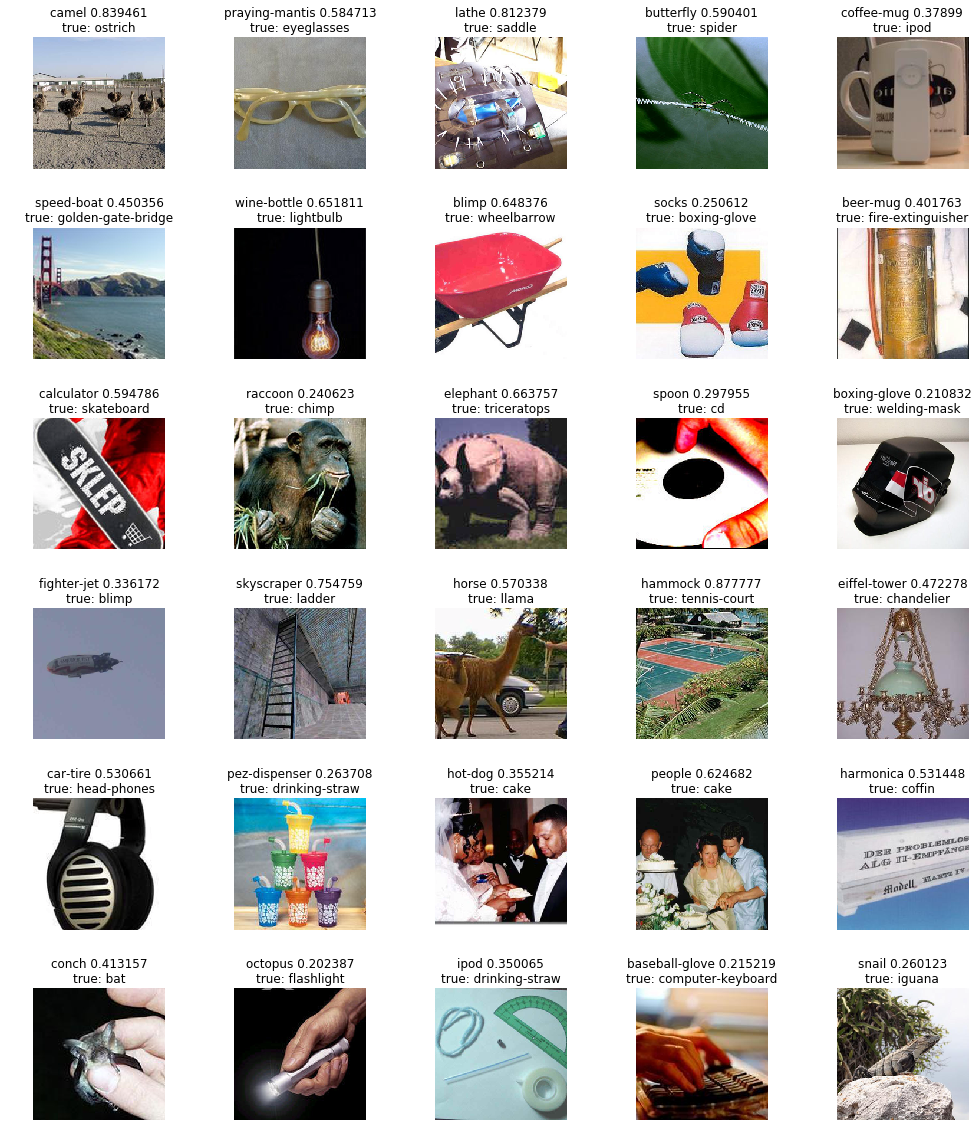

In [37]:
# show pictures, predicted classes and probabilities
_, axes = plt.subplots(nrows=6, ncols=5, figsize=(14, 16))
axes = axes.flatten()
for i, pic in enumerate(pictures):
    axes[i].set_axis_off();
    axes[i].imshow(pic);
    title = decode[pictures_predictions[i] + 1] + ' ' +\
        str(pictures_probs[i]) + '\ntrue: ' + decode[pictures_true[i] + 1]
    axes[i].set_title(title);
plt.tight_layout()

# Save the model

In [38]:
for i, m in enumerate(all_models):
    torch.save(m, 'model_state' + str(i) + '.pytorch')